#### Library Import

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from numpy.linalg import norm
from sklearn.decomposition import PCA
from glob import glob

C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

### 1. Creating the model

In [2]:
model = VGG16(weights="imagenet", include_top=False)  #Only the feature extraction layers are required.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### 2. Auxiliary Functions

#### <p style = "color:red">Extracting image features and resizing the tensors. </p>

In [ ]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(650,500))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return(model.predict(x))

def reduce_dimensions(features):
    pca = PCA()
    features = features.reshape(20,15*512)
    pca.fit(features)
    features_trans = pca.transform(features)
    return(np.squeeze(features_trans.reshape(1,400)))

#### Calculating Image Similarity Scores

<li>Image similarity is calculated as cosine similarity of extracted and resized features of two images.</li>
<li>Higher the similarity score, more different the images. Two same images will have a similarity score of 0.</li>
<li>Two types of images similarity scores: <li> <b>Image similarity intra </b> is the mean of image similarity score of every image with all other images in the image set. </li> <li><b>Image similarity cross</b> is the mean of all of the image similarity scores between the images across all the given image sets. </li></li>
<li>Image similarity intra will compare one image set while cross will assess multiple image sets. </li>

In [3]:
def img_sim_score(features_1, features_2):
    sim = (np.dot(features_1,features_2))/(norm(features_1,2)*norm(features_2,2))
    return(1-sim) 

def img_sim_iterator(image_set_1, image_set_2, img_sim_type):
    final_list = []
    if img_sim_type == 'intra' and all(np.array_equal(m, n) for m, n in zip(image_set_1, image_set_2)):
        for i in range(0,len(image_set_1)):
            for j in range(0,len(image_set_2)):
                if not image_set_1[i].all == image_set_2[j].all:
                    final_list.append(img_sim_score(image_set_1[i],image_set_2[j]))
    elif img_sim_type == 'cross' and not (all(np.array_equal(m, n) for m, n in zip(image_set_1, image_set_2))):
        for i in range(0,len(image_set_1)):
            for j in range(0,len(image_set_2)):
                final_list.append(img_sim_score(image_set_1[i],image_set_2[j]))
    return final_list  

def img_sim_intra_calculator(image_list):
    feat_list = []
    for img in image_list:
        feat_list.append(reduce_dimensions(extract_features(img)))
    return np.mean(img_sim_iterator(feat_list, feat_list, 'intra'))

def img_sim_cross_calculator(image_list):
    feat_list_combined = []
    for ls in image_list:
        feat_list = []
        for img in ls:
            feat_list.append(reduce_dimensions(extract_features(img)))
        feat_list_combined.append(feat_list)
    isc_list = []
    for i in range(0,len(feat_list_combined)):
        temp = feat_list_combined.pop()
        for i in range(0,len(feat_list_combined)):
            isc_list.append(np.mean(img_sim_iterator(temp,feat_list_combined[i],'cross')))
    return np.mean(isc_list)

### 3. Calculating Image Similarity Scores

#### Loading the images

In [7]:
diverse_dataset = [f for f in glob(f'Faces/DiverseDataset/*')]
ffhq = [f for f in glob(f'Faces/FFHQ/*')]
imdb = [f for f in glob(f'Faces/IMDB/*')]
lfw = [f for f in glob(f'Faces/LFW/*')]
utk = [f for f in glob(f'Faces/UTK/*')]
wiki = [f for f in glob(f'Faces/WIKI/*')]

#### Calculating Img_Sim Scores

In [8]:
diverse_dataset_sc = img_sim_intra_calculator(diverse_dataset)
ffhq_sc = img_sim_intra_calculator(ffhq)
imdb_sc = img_sim_intra_calculator(imdb)
lfw_sc = img_sim_intra_calculator(lfw)
utk_sc = img_sim_intra_calculator(utk)
wiki_sc = img_sim_intra_calculator(wiki)

In [20]:
scores_list = [diverse_dataset_sc,ffhq_sc,imdb_sc,lfw_sc,utk_sc,wiki_sc]
dataset_list = ['Diverse Dataset','FFHQ','IMDB','LFW','UTK','WIKI']

### 4. Creating Result Dataset

In [30]:
result_df = pd.DataFrame(list(zip(dataset_list,scores_list)),columns=['Dataset','ImgSimScore_Intra'])

In [31]:
result_df = result_df.sort_values('ImgSimScore_Intra', ascending=False)
result_df = result_df.reset_index()
result_df = result_df.drop('index', axis=1)

In [35]:
result_df.to_csv('results.csv', index=False)

In [36]:
result_df

,Dataset,ImgSimScore_Intra
0,FFHQ,0.994070
1,Diverse Dataset,0.989534
2,WIKI,0.978636
3,IMDB,0.966186
4,LFW,0.953636
5,UTK,0.941871


### 5. Visualisations

In [2]:
import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [3]:
result_df = pd.read_csv('results.csv')

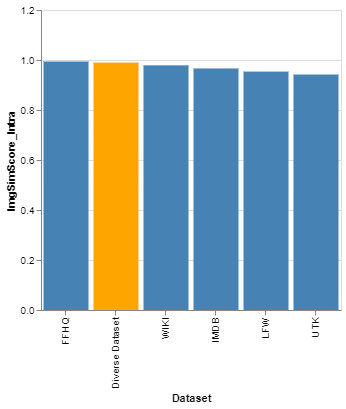

In [46]:
alt.Chart(result_df).mark_bar().encode(
    alt.X("Dataset", sort=alt.EncodingSortField(field="Letters", op="count", order='ascending')),
    y=alt.Y('ImgSimScore_Intra', scale=alt.Scale(domain=[0, 1.2])),
    color=alt.condition(
        alt.datum.Dataset == 'Diverse Dataset',  
        alt.value('orange'),    
        alt.value('steelblue')
)).properties(width=300)